## Numeryczne Rozwiązywanie Rónań Różniczkowych Zwyczajnych
### Uniwersytet Jagielloński 2023
Katedra Teorii Optymalizacji i Sterowania UJ

In [20]:
import numpy as np
from numpy import sin, cos, exp, sqrt
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## Równanie różniczkowe zwyczajne rzędu 2

Każde równanie różniczkowe rzędu n można traktować jako układ równań n równań różniczkowych rzędu 1.

Rozważmy RRZ rzędu 2:

$x''(t) = f(t, x, x')$

$t \in [a, b]$   

$x(a) = \alpha, \quad x'(a) = \gamma$

Zastosujmy podstawienie: $y = x'$, wtedy:

$x'(t) = y = f_0(t, x, y)$

$y'(t) = f_1(t, x, y)$

Przechodząc na przestrzeń wektorów $R^2$ mamy dobrze znane równanie:

$𝐱'(t) = 𝐟(t, 𝐱)$

z warunkiem początkowym $𝐱(a) = (\alpha, \gamma)$.

In [39]:
def rk4(dxdt, t, x, h):
    k1 = h * dxdt(t, x[-1])
    k2 = h * dxdt(t + 0.5 * h, x[-1] + 0.5 * k1)
    k3 = h * dxdt(t + 0.5 * h, x[-1] + 0.5 * k2)
    k4 = h * dxdt(t + h, x[-1] + k3)
    return x[-1] + (k1 + 2 * k2 + 2 * k3 + k4) / 6

def initial_value_problem(f, h=0.01, a=0, b=1, alpha=0, gamma=1):
    y = [np.asarray([alpha, gamma])]
    t = [a]
    def fp(t, y):
        return np.asarray([y[1], f(t, y)])
    next_t = t[-1] + h
    while next_t <= b:
        y.append(rk4(fp, t[-1], y, h))
        t.append(next_t)
        next_t += h
    return np.asarray(t), np.asarray(y)

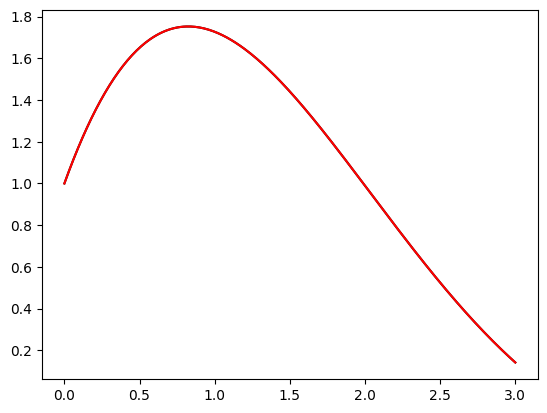

In [40]:
t, x = initial_value_problem(f=lambda t, x: -x[1] - x[0], a=0, b=3, alpha=1, gamma=2, h=0.01)
plt.plot(t, x[:, 0], color="black")
plt.plot(t, exp(-0.5 * t) * (5/sqrt(3) * sin(sqrt(3) / 2 * t) + cos(sqrt(3) / 2 * t)), color="red")

## Metoda strzałów


#### Funkcja phi

In [15]:
t = np.linspace(0, 1, 500)

def rhs(t):
    # -x'' + 400 x = -400 cos^2(pi t) - 2pi^2 cos(2pi t)
    # x'' = 400 x + 400 cos^2(pi t) + 2pi^2 cos(2pi t)
    return 400*np.cos(np.pi*t)**2 + 2*np.pi**2*np.cos(2*np.pi*t)

# phi(z) = x(1; z)  where x(0)=  –1, x'(0) = z
def phi(z):
    sol = solve_ivp(
        fun=lambda tt,y: [y[1], 400*y[0] + rhs(tt)],
        t_span=(0,1),
        y0=[-1, z],
        t_eval=[1]
    )
    return sol.y[0,-1]   # x(1)

#### Pochodna funkcji phi

In [16]:
# phi′(z) = d/dz (x(1;z)) = u(1), where u'' = 400 u, u(0)=0, u'(0)=1
def d_phi(z):
    def augmented(tt, Y):
        x, xdot, u, udot = Y
        return [
            xdot,
            400*x + rhs(tt),
            udot,
            400*u
        ]
    # initial x, x', u, u'
    Y0 = [-1, z, 0, 1]
    sol = solve_ivp(augmented, (0,1), Y0, t_eval=[1])
    return sol.y[2,-1]   # u(1)

#### Metoda Newtona

In [17]:
# 4) Newton iteration to find z* such that φ(z*) = 0, then re‐integrate to get x(t)
def newton(phi_func, z0, tol=1e-10, maxit=20):
    z = z0
    for i in range(maxit):
        fz = phi_func(z)
        dfz = d_phi(z)
        dz = -fz/dfz
        z += dz
        if abs(dz) < tol:
            break
    # now integrate once more with the “corrected” slope
    sol = solve_ivp(
        fun=lambda tt,y: [y[1], 400*y[0] + rhs(tt)],
        t_span=(0,1),
        y0=[-1, z],
        t_eval=t
    )
    return sol.y[0]

In [18]:
# 5) exact solution for comparison
def exact(t):
    A = np.exp(-20)/(1+np.exp(-20))
    return A*np.exp(20*t) + A*np.exp(-20*t) - np.cos(np.pi*t)**2

In [21]:
z0 = 0.0
x_shooting = newton(phi, z0)


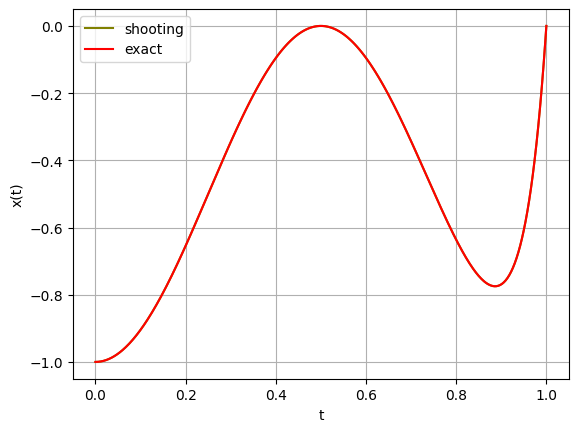

In [22]:
plt.plot(t, x_shooting, color="olive", label="shooting")
plt.plot(t, exact(t),    color="red",   label="exact")
plt.legend()
plt.grid()
plt.xlabel("t")
plt.ylabel("x(t)")
plt.show()

## Metoda różnic skończonych


#### Konstrukcja układu równań

In [29]:
n = 101
t = np.linspace(0, 1, n)
h = t[1] - t[0]
h = 1/(n-1)
m = n-2  # interior points

In [30]:
# build the tridiagonal matrix A of size m×m
main_diag = (2/h**2 + 400)*np.ones(m)
off_diag  = (-1/h**2)  *np.ones(m-1)
a = np.diag(main_diag) + np.diag(off_diag,  1) + np.diag(off_diag, -1)

In [31]:
# build the RHS vector g(t_i) at the interior nodes i=1…n-2
g = -400*np.cos(np.pi*t)**2 - 2*np.pi**2*np.cos(2*np.pi*t)
b = g[1:-1].copy()

# incorporate Dirichlet BCs x(0)=-1, x(1)=0
b[0]   += (1/h**2)*(-1)   # from the term -x'' ≈ -(x₁ - 2x₀ + x_{-1})/h²
# b[-1] += (1/h**2)*(0)  # right boundary is zero so no change

#### Rozwiązanie układu równań

In [32]:
# solve for the interior values
x_int = np.linalg.solve(a, b)

# assemble the full solution vector
x_finite_diff = np.empty_like(t)
x_finite_diff[0]   = -1
x_finite_diff[-1]  =  0
x_finite_diff[1:-1] = x_int


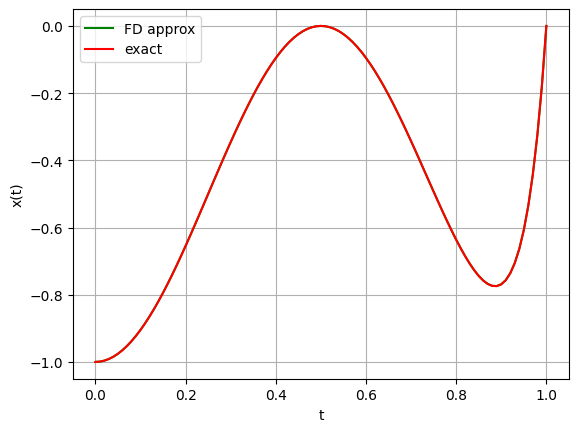

In [33]:
# now plot
plt.plot(t, x_finite_diff, color="green", label="FD approx")
plt.plot(t, exact(t),    color="red",   label="exact")
plt.legend()
plt.grid()
plt.xlabel("t")
plt.ylabel("x(t)")
plt.show()


In [34]:
A = np.exp(-20)/(1 + np.exp(-20))
def x_exact(t):
    return A*np.exp(20*t) + A*np.exp(-20*t) - np.cos(np.pi*t)**2

def dx_exact(t):
    return 20*A*(np.exp(20*t) - np.exp(-20*t)) + np.pi*np.sin(2*np.pi*t)

def d2x_exact(t):
    return 400*A*(np.exp(20*t) + np.exp(-20*t)) + 2*(np.pi**2)*np.cos(2*np.pi*t)

In [35]:
# Grid setup
n = 101
t = np.linspace(0, 1, n)
h = t[1] - t[0]
x = x_exact(t)

In [ ]:
# Grid setup
n = 101
t = np.linspace(0, 1, n)
h = t[1] - t[0]
x = x_exact(t)

In [36]:
# Finite-difference approximations

# 1) Forward difference (i) - order 1
df_forward = np.empty_like(x)
df_forward[:-1] = (x[1:] - x[:-1]) / h
df_forward[-1] = np.nan

# 2) Backward difference (ii) - order 1
df_backward = np.empty_like(x)
df_backward[0] = np.nan
df_backward[1:] = (x[1:] - x[:-1]) / h

# 3) Central difference (iii) - order 2
df_central = np.empty_like(x)
df_central[0] = np.nan
df_central[-1] = np.nan
df_central[1:-1] = (x[2:] - x[:-2]) / (2*h)

# 4) Second-derivative central (iv) - order 2
d2_fd = np.empty_like(x)
d2_fd[0] = np.nan
d2_fd[-1] = np.nan
d2_fd[1:-1] = (x[2:] - 2*x[1:-1] + x[:-2]) / (h**2)

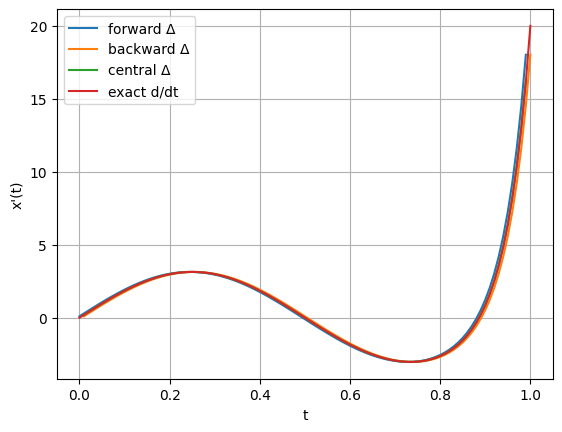

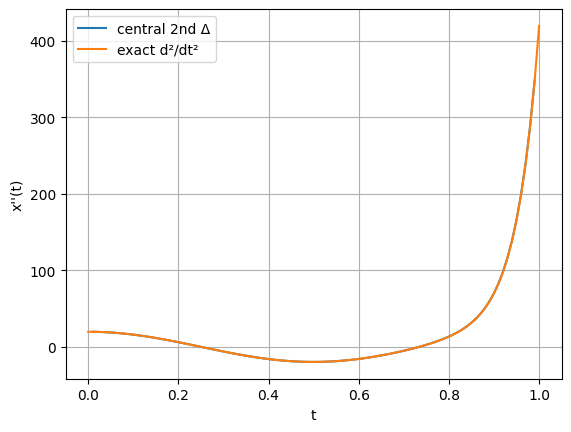

In [38]:
# Plot for first derivative schemes
plt.plot(t, df_forward, label='forward Δ')
plt.plot(t, df_backward, label='backward Δ')
plt.plot(t, df_central, label='central Δ')
plt.plot(t, dx_exact(t), label='exact d/dt')
plt.legend()
plt.grid()
plt.xlabel('t')
plt.ylabel("x'(t)")
plt.show()

# Plot for second-derivative scheme
plt.plot(t, d2_fd, label='central 2nd Δ')
plt.plot(t, d2x_exact(t), label='exact d²/dt²')
plt.legend()
plt.grid()
plt.xlabel('t')
plt.ylabel("x''(t)")
plt.show()